In [1]:
import string
import random
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from ipywidgets import interactive, HBox, VBox
from img_processing import preprocess_img, DITHER_MODES
from ascii_art_non_mono_utils import *

In [2]:
font_path = "fonts/OpenSans-Regular.ttf"
size = 20
fnt = ImageFont.truetype(font_path, size)

In [3]:
orig_img = Image.open("imgs/irad_grad.bmp").convert("L")
#orig_img = ImageOps.invert(orig_img)

print(orig_img.size)

(512, 512)


In [4]:
def i_preprocess_img(scale_factor, contrast, brightness, quantize_colors, eq, dither):
    proc_img = preprocess_img(orig_img, scale_factor, 1.1, 0.9, 0.2, 128, DITHER_MODES.NONE)
    plt.imshow(proc_img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.figure(figsize=(9, 3))
    plt.xticks([x for x in range(0, len(proc_img.histogram()), 25)])
    plt.bar([x for x in range(0, len(proc_img.histogram()))], proc_img.histogram())
    plt.grid()
    plt.show()

    return proc_img

interactive_preprocess = interactive(i_preprocess_img,
            scale_factor=(0.01, 1, 0.01),
            contrast=(0, 2, 0.01),
            brightness=(0, 2, 0.01),
            eq=(0, 1, 0.01),
            quantize_colors=(1, 256, 1),
            dither=DITHER_MODES)

controls = VBox(interactive_preprocess.children[:-1])
display(HBox((controls, interactive_preprocess.children[-1])))

In [5]:
proc_img = interactive_preprocess.result

In [6]:
palette = list(filter(lambda a: a.isprintable(), string.printable))
print(palette)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [7]:
bg_img, draw = new_img_draw(proc_img.size)
text = []
bbox = draw.textbbox((0,0), ''.join(text), font=fnt)
img_size = proc_img.size
lines = []
while bbox[3] < img_size[1]:
    text.append(''.join(palette) + '\n')
    bbox = draw.textbbox((0,0), ''.join(text), font=fnt)

print(len(text))
line_width = proc_img.size[0]
line_hight = proc_img.size[1] // len(text)
lines = []
for i in range(len(text)):
    lines.append(proc_img.crop((0, i * line_hight, line_width, (i+1) * line_hight)))

for l in lines:
    display(l)
line = lines[len(lines) // 2]
line

10


In [8]:
def generate_random_line():
    line_size = line.size
    bg_img = Image.new("L", line_size, 0)

    draw = ImageDraw.Draw(bg_img)

    text = []

    bbox = draw.textbbox((0,0), ''.join(text), font=fnt)

    while line_size[0] > bbox[2]:
        text.append(palette[random.randint(0, len(palette)-1)])
        bbox = draw.textbbox((0,0), ''.join(text), font=fnt)
    text.pop()
    draw.text((0,0), ''.join(text), font=fnt, fill=255)
    return bg_img

generate_random_line()

In [9]:
def new_random_solution(line, last_solution):
    r_l = generate_random_line()
    diff = ImageChops.difference(line, r_l)
    last_diff = ImageChops.difference(line, last_solution)
    if np.sum(diff) < np.sum(last_diff):
        return r_l
    else:
        return last_solution


In [10]:

sol = new_random_solution(line, generate_random_line())
print(np.average(ImageChops.difference(line, sol)))
sol

136.73734375


In [11]:
for i in range(0, 1000):
    sol = new_random_solution(line, sol)
    if (i % 1000 == 0):
        print(np.average(ImageChops.difference(line, sol)))

print(np.average(ImageChops.difference(line, sol)))
sol

136.73734375
134.62171875


In [12]:
def generate_greedy_line(line):
    line_size = line.size
    bg_img, draw = new_img_draw(line_size)

    text = []

    bbox = draw.textbbox((0,0), ''.join(text), font=fnt)

    while line_size[0] > bbox[2]:
        best_c = palette[0]
        text.append(palette[0])
        draw.text((0,0), ''.join(text), font=fnt, fill=255)
        best_c_diff = np.average(ImageChops.difference(line, bg_img))
        text.pop()
        clear_img(draw, line_size)
        for i in range(1, len(palette)):
            text.append(palette[i])
            draw.text((0,0), ''.join(text), font=fnt, fill=255)
            diff = np.average(ImageChops.difference(line, bg_img))
            if diff < best_c_diff:
                best_c = palette[i]
                best_c_diff = diff
            text.pop()
            clear_img(draw, line_size)
        text.append(best_c)
        bbox = draw.textbbox((0,0), ''.join(text), font=fnt)
    text.pop()
    draw.text((0,0), ''.join(text), font=fnt, fill=255)
    return text, bg_img

In [13]:
text_l, g_l = generate_greedy_line(line)
print(np.average(ImageChops.difference(line, bg_img)))
print(text_l)
g_l

156.0484375
[' ', 'i', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', 'j', ' ']


In [14]:
text = []
for l in lines:
    text_l, g_l = generate_greedy_line(l)
    text_l.append('\n')
    text.append(''.join(text_l))
    display(g_l)

In [15]:
print(''.join(text))

                jjjjjjjjjjjjjjjjjjjj               
        jjj@@@@@@@@jjj        
     j@@@@@@@@@@jjjjj    
  jj@@@@@@@@@@@@jj 
 j@@@@@@@@@@@@@j 
 i@@@@@@@@@@@@@j 
  i@@@@@@@@@@@@jjl 
    il@@@@@@@@@@jllll    
        lll@@@@@@@@lll        
                llllllllllllllllllll               



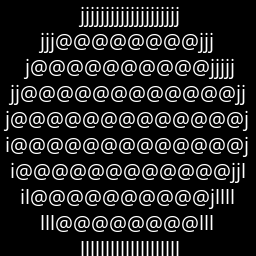

In [16]:
bg_img, draw = new_img_draw(proc_img.size)
draw.multiline_text((0,0), ''.join(text), font=fnt, fill=255)
bg_img